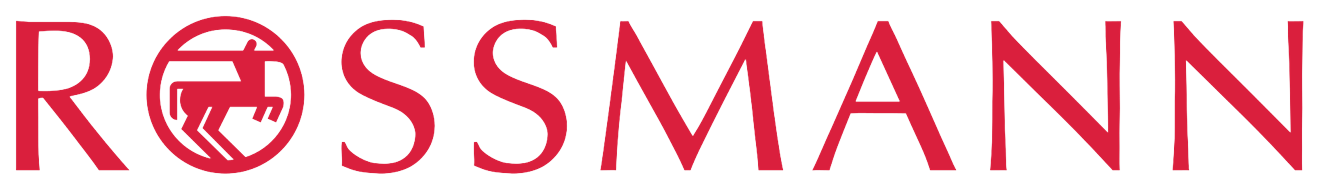

# 1- Contextualização

Rossmann é uma rede de drogarias que opera com mais de 3.000 unidades espelhadas em 7 países da Europa. 

Em uma reunião mensal de apresentação de resultados mensais, o CFO solicitou a todos os gerentes que enviassem um relatório com uma previsão de vendas para as próximas 6 semanas para que ele decida sobre a viabilidade de uma reforma nas lojas.

As lojas são influenciadas por muitos fatores como: Promoções, Competições, Feriados escolas e estaduais, sazonalidade e localidade pois cada loja possui circunstâncias únicas que podem influenciar na variabilidade dos resultados de acurácia do modelo de predição que deverá ser implementado.

# 2- Bibliotecas 

In [1]:
import pandas as pd
import inflection
import HelpFunctions
import math
import numpy as np
import seaborn as sns

# 3- Dados

## 3.1 - Carga

In [2]:
df_raw1 = pd.read_csv(r'dataset\raw1.csv', low_memory=False)
df_raw2 = pd.read_csv(r'dataset\raw2.csv', low_memory=False)

df_raw = pd.merge(left=df_raw1, right=df_raw2, how='left', on='Store')

In [3]:
df_raw.sample()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
219946,243,a,a,310.0,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov",4,2015-05-14,0,0,0,0,a,0


### 3.2 - Descrição dos dados

Colunas / Features | Descrição
:------------------ | :---------:
Store              | Número de identificação da loja. Cada Loja possui um ID único.
Store Type         | Diferencia entre 4 modelos de lojas diferentes: a, b, c, d
Assortment         | Descreve um nível de produtos existentes na loja : a = básico, b = extra, c = estendido
CompetitionDistance | Distância em metros até a loja concorrente mais próxima
CompetitionOpenSinceMonth | O mês aproximado da abertura da loja concorrente mais próxima
CompetitionOpenSinceYear | O ano aproximado da abertura da loja concorrente mais próxima
Promo2 | Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando
Promo2SinceWeek | Descreve a semana em que a loja começou a participar do Promo2
Promo2SinceYear | Descreve o ano em que a loja começou a participar do Promo2
PromoInterval | Descreve os intervalos consecutivos em que o Promo2 é iniciado, nomeando os meses em que a promoção é iniciada novamente. Por exemplo. "Fevereiro, maio, agosto, novembro" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para essa loja
DayOfWeek | Dias da semana
Date | Data
Sales | Volume de Vendas para qualquer dia (ESTÁ É A VARIÁVEL TARGET)
Customers | O volume de clientes em um determinado dia
Open | Um indicador para saber se a loja estava aberta: 0 = fechado, 1 = aberto
Promo | Indica se uma loja está realizando uma promoção naquele dia
StateHoliday | Indica um feriado estadual. Normalmente todas as lojas, com poucas exceções, fecham nos feriados estaduais. Observe que todas as escolas fecham nos feriados e fins de semana. a = feriado, b = feriado da Páscoa, c = Natal, 0 = nenhum
SchoolHoliday | Indica se a (Loja, Data) foi afetada pelo fechamento das escolas públicas

### 3.3 - Renomeando as colunas (Snake Case Type)

In [4]:
df1 = df_raw.copy()

old_cols = df1.columns

snake_case = lambda x : inflection.underscore(x)

new_cols = list(map(snake_case, old_cols))

df1.columns = new_cols

df1.columns

Index(['store', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'promo_interval',
       'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday'],
      dtype='object')

### 3.4 - Dimensões dos dados

In [5]:
df1.shape

(1017209, 18)

### 3.5 - Valores Duplicados

In [6]:
df1 = df1.drop_duplicates()

### 3.6 - Valores NA

In [7]:
df1.isna().sum()

store                                0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
dtype: int64

Observe que, no conjunto de dados, existem algumas colunas e muitas linhas com valores NA. Essas informações faltantes devem ser tratadas de acordo com o negócio.

### 3.6.1 - Analisando as variáveis com dados faltantes

#### VARIÁVEIS: 'competition_distance', 'competition_open_since_month', 'competition_open_since_year'

De acordo com o **NEGÓCIO**, as variáveis estão interligadas e os valores atribuídos as variáveis 'competition_open_since_month', 'competition_open_since_year' dependem do valor da variável 'competition_distance'.

O valor NA da variável 'competition_distance' pode indicar que não há, nas proximidades, lojas concorrentes.

Atribuir valor 0 nesta variável pode ocasionar problemas pois o valor distância 0 metros pode indicar que existe uma loja concorrente com distância menor que 1 metro.

Optei em realizar a seguinte lógica:

    1- Encontrar o valor máximo da coluna 'competition_distance'.
    2- Atribuir aos valores faltantes da variável 'competition_distance' valores 2 x acima da maior distância encontrada na coluna. Garantindo numericamente que não há nenhum concorrente nas proximidades.
    3- Para as colunas 'competition_open_since_month', 'competition_open_since_year':
        3.1 - Se a coluna 'competition_distance' for <= ao valor máximo desta coluna, então eu vou extrair da coluna date o mês e o ano e preencher os valores NA das colunas.
        3.2 - Se a coluna 'competition_distance' for > ao valor máximo desta coluna, então será atrituído o valor 0 pois não há competidores próximos.
        
Antes de realizar esse procedimento é necessário transformar o tipo da coluna 'date' como data 

In [8]:
# Alterando o tipo da coluna 'date' para datetime
df1['date'] = pd.to_datetime(df1['date'])

# Encontrando o valor máximo da coluna 'competition distance' e multiplicando por 2
max_distance = df1['competition_distance'].max()

# Atribuindo a variável max_distance nas linhas da coluna 'competition_distance' que possuem valores NA
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: max_distance * 2 if math.isnan(x) else x)

# Verificando a existência de valores NA na variável 'competition_distance' após a atribuição acima
df1['competition_distance'].isna().sum()

0

In [9]:
# Removendo valores NA das colunas 'competition_open_since_month' de acordo com a lógica da análise.
for i in df1.index:
    if df1.loc[i,'competition_distance'] > max_distance:
        df1.loc[i,'competition_open_since_month'] = 0

for i in df1.index:
    if (math.isnan(df1.loc[i,'competition_open_since_month'])) & (df1.loc[i,'competition_distance'] <= max_distance):
        df1.loc[i,'competition_open_since_month'] = df1.loc[i,'date'].month
        
# Verificando a existência de valores NA na variável 'competition_open_since_month' após a atribuição acima
df1['competition_open_since_month'].isna().sum()

0

In [10]:
# Removendo valores NA das colunas 'competition_open_since_year' de acordo com a lógica da análise.
for i in df1.index:
    if df1.loc[i,'competition_distance'] > max_distance:
        df1.loc[i,'competition_open_since_year'] = 0

for i in df1.index:
    if (math.isnan(df1.loc[i,'competition_open_since_year'])) & (df1.loc[i,'competition_distance'] <= max_distance):
        df1.loc[i,'competition_open_since_year'] = df1.loc[i,'date'].year
        
# Verificando a existência de valores NA na variável 'competition_open_since_year' após a atribuição acima
df1['competition_open_since_year'].isna().sum()

0

#### VARIÁVEIS: 'promo2_since_week', 'promo2_since_year', 'promo_interval'


De acordo com o **NEGÓCIO**, estas variáveis também estão interligadas e os valores atribuídos as variáveis 'promo2_since_week', 'promo2_since_year' e 'promo2_interval' dependem do valor da variável 'promo2'.

A variável 'promo2' indica se a loja está ou não participando de algum promoção. Se a loja estiver com status 0 nesta coluna, indica que ela não participa de nenhuma promoção e as colunas 'promo2_since_week', 'promo2_since_year' e 'promo2_interval' serão configuradas como 0.

Observando os valores possíveis da variável 'promo2' podemos constatar que, o mesmo número de valores NA corresponde aos valores cujas lojas não participaram de nenhuma promoção (veja abaixo e compare com os valores na das variáveis 'promo2_since_week', 'promo2_since_year' e 'promo2_interval').

Portanto basta apenas substituir os valores NA por 0 nas três variáveis.

In [11]:
# Verificando os valores possíveis da variável 'promo2'
df1['promo2'].value_counts()

promo2
1    509178
0    508031
Name: count, dtype: int64

In [12]:
# Substituindo os valoes NA por 0 das variáveis 'promo2_since_week', 'promo2_since_year', 'promo2_interval'
df1['promo2_since_week'] = df1['promo2_since_week'].fillna(0)
df1['promo2_since_year'] = df1['promo2_since_year'].fillna(0)
df1['promo_interval'] = df1['promo_interval'].fillna(0)

# Verificando os valores NA
print(df1['promo2_since_week'].isna().sum())
print(df1['promo2_since_year'].isna().sum())
print(df1['promo_interval'].isna().sum())

0
0
0


### 3.7 - Tipo de dados

In [13]:
df1.dtypes

store                                    int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
dtype: object

De acordo com a descrição das colunas no item 3.2 observa-se que o tipo dos dados não corresponde com a descrição: competition_open_since_month, competition_open_since_year, promo2_since_week, promo2_since_year estão com o tipo atribuído erroneamente e portanto devem ser alterados.

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
print(df1['competition_open_since_month'].dtypes)

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
print(df1['competition_open_since_year'].dtypes)

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
print(df1['promo2_since_week'].dtypes)

df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
print(df1['promo2_since_year'].dtypes)

int64
int64
int64
int64


### 3.8 - Estatística Descritiva (Resumo dos dados Numéricos)

#### 3.8.1 - Resumo dos dados numéricos

In [15]:
# Selecionando os dados numéricos do conjunto de dados
df1_num = df1.select_dtypes(include=['int64','float64'])

# Medidas de Tendência Central (média, media)
media = pd.DataFrame(df1_num.apply(lambda x : x.mean())).T
mediana = pd.DataFrame(df1_num.apply(lambda x : x.median())).T
                     
# Medidas de Dispersão dos dados (mínimo, máximo, range, desvio padrão, curtose, skew)
minimo = pd.DataFrame(df1_num.apply(np.min)).T
maximo = pd.DataFrame(df1_num.apply(np.max)).T
faixa = pd.DataFrame(df1_num.apply(lambda x : x.max() - x.min())).T
desvio = pd.DataFrame(df1_num.apply(lambda x : x.std())).T
curtose = pd.DataFrame(df1_num.apply(lambda x : x.kurtosis())).T
skewness = pd.DataFrame(df1_num.apply(lambda x : x.skew())).T

medidas = pd.concat([minimo, maximo, faixa, desvio, media, mediana, curtose,skewness]).T.reset_index()

medidas.columns = ['variável', 'minimo', 'máximo', 'faixa', 'desvio', 'média', 'mediana', 'curtose','skewness']

medidas

,variável,minimo,máximo,faixa,desvio,média,mediana,curtose,skewness
0,store,1.0,1115.0,1114.0,321.908651,558.429727,558.0,-1.200524,-0.000955
1,competition_distance,20.0,151720.0,151700.0,10715.012901,5810.044888,2330.0,90.447876,7.593832
2,competition_open_since_month,0.0,12.0,12.0,3.324383,6.772004,7.0,-1.222250,-0.048558
3,competition_open_since_year,0.0,2015.0,2015.0,102.468513,2005.094323,2012.0,377.806282,-19.461189
4,promo2,0.0,1.0,1.0,0.500000,0.500564,1.0,-1.999999,-0.002255
5,promo2_since_week,0.0,50.0,50.0,15.323928,11.647665,1.0,-0.498322,1.003390
6,promo2_since_year,0.0,2015.0,2015.0,1005.876930,1007.010608,2009.0,-1.999993,-0.002251
7,day_of_week,1.0,7.0,6.0,1.997391,3.998341,4.0,-1.246873,0.001593
8,sales,0.0,41551.0,41551.0,3849.926175,5773.818972,5744.0,1.778375,0.641460
9,customers,0.0,7388.0,7388.0,464.411734,633.145946,609.0,7.091773,1.598650


3.8.1.1 - Análise

A estatística descritiva nos permite ter uma ideia de como os dados estão distribuídos dentro do conjunto.

Nesta primeira etapa de conhecimento dos dados podemos ter alguns insights básicos do negócio.

**competition_distance**

    Esta variável como descrita anteriormente, mostra a distância entre os competidores. 
    Podemos observar que:

        1- A menor distância são 20 metros.
        2- A distância mediana entre os competidores é de 2.330 metros ou 2Km aproximadamente. 
        3- Existem muitas lojas competidoras muito próximas uma das outras como podemos observar através da curtose que descreve um pico positivo muito alto.
        
    O gráfico abaixo ilustra as análises realizadas:

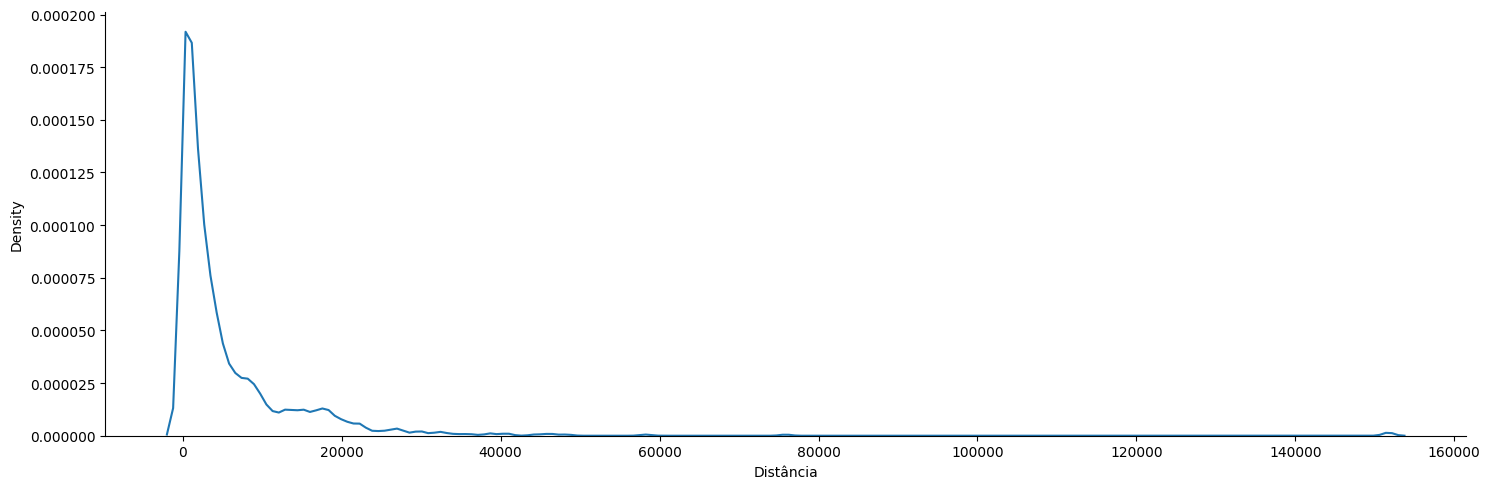

In [70]:
histograma = sns.displot(data=df1, x=df1['competition_distance'], kind='kde',height=5,aspect=3)
histograma.set_xlabels(label='Distância')
histograma;

**sales**

    Esta variável como descrita anteriormente, mostra o volume de vendas das lojas.
    Podemos observar que:
        
        1- A média do volume de vendas das lojas é de 5.700.
        2- De acordo com a curtose, média, mediana e skew, a distribuição dos dados é bem aproximada a uma distribuição normal uniforme.
        3- 41.551 foi o volume máximo de vendas.
    
    O gráfico abaixo ilustra as análises realizadas:

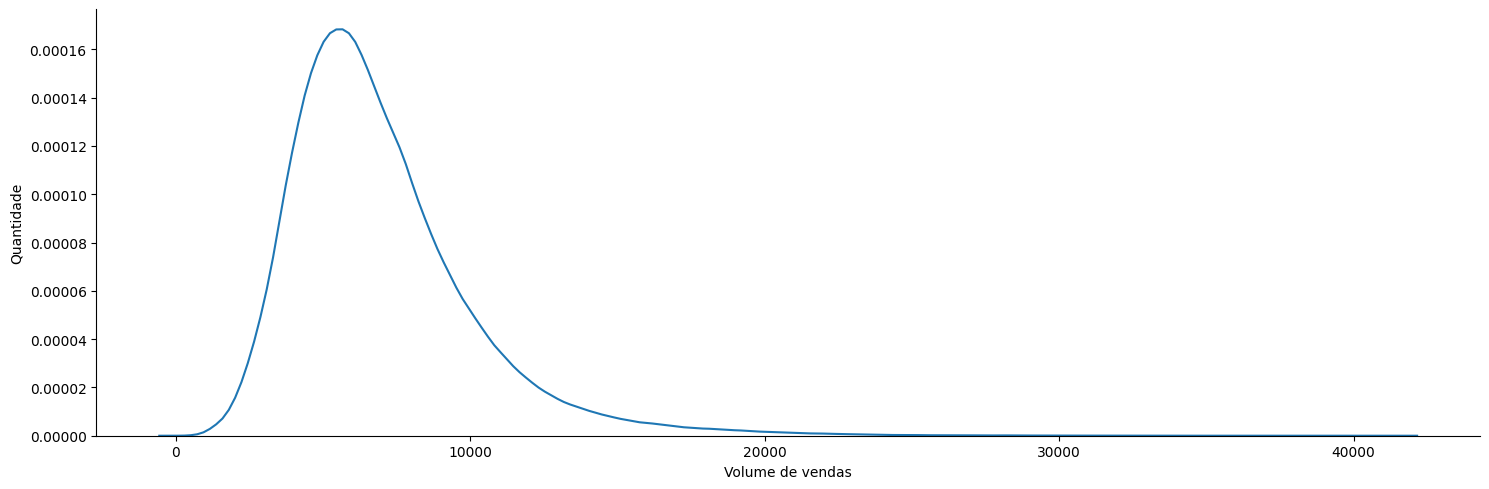

In [68]:
# Antes de criar o gráfico devemos filtrar o volume de vendas cujo valor = 0 pois indicam que as lojas estavam fechadas
df_aux = df1.loc[df1['sales'] > 0]

histograma = sns.displot(data=df_aux, x=df_aux['sales'], kind='kde',height=5,aspect=3)
histograma.set_xlabels(label='Volume de vendas')
histograma;

**customers**

    Esta variável como descrita anteriormente, mostra o volume de clientes nas lojas.
    Podemos observar que:
        
        1- A média clientes nas lojas é de 633.
        2- De acordo com a curtose, média, mediana e skew, a distribuição dos dados é bem aproximada a uma distribuição normal uniforme.
        3- 7.388 foi o número máximo de clientes.
    
    O gráfico abaixo ilustra as análises realizadas:

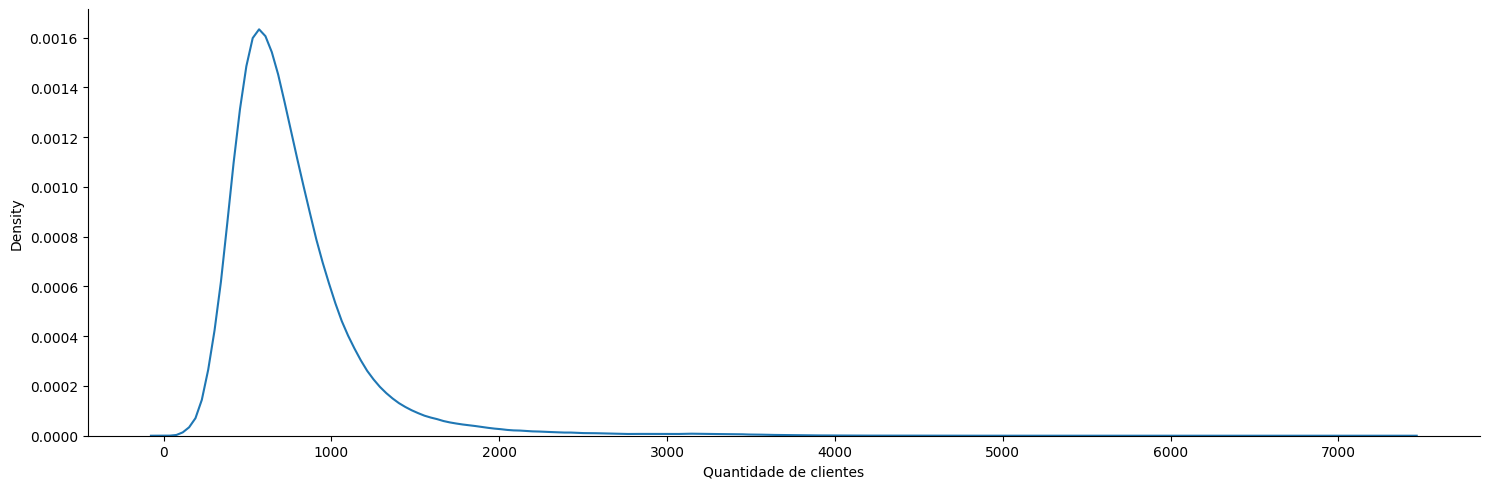

In [71]:
# Antes de criar o gráfico devemos filtrar o volume de vendas cujo valor = 0 pois indicam que as lojas estavam fechadas
df_aux = df1.loc[df1['customers'] > 0]

histograma = sns.displot(data=df_aux, x=df_aux['customers'], kind='kde',height=5,aspect=3)
histograma.set_xlabels(label='Quantidade de clientes')
histograma;

#### 3.8.2 - Resumo dos dados Categóricos

In [16]:
# Selecionando os dados categóricos do conjunto de dados
df1_cat = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])
